In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [2]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfg = [c for c in configs if 'simple_exp' in c['name'] 
                    and c['config']['training']['num_epochs'] == 1500
                    and c['config']['model']['layers'] == 4
                    and c['config']['dataset']['n_sets'] == 10_000
                    and c['config']['dataset']['prior'] == 'uniform']

In [3]:
import hydra
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

In [4]:
ds_cfg = cfg[0]['config']['dataset']
ds_cfg['prior_params'] = (-10, 10)
ds_cfg['prior'] = 'uniform'
ds_cfg['n_sets'] = 1_000
ds_cfg['set_size'] = 1_000
ds_cfg['data_shape'] = (5,)
ds_cfg['seed'] = 42


In [5]:
num_samples = 300
dataset = prepare_dataset(ds_cfg)

In [9]:
import torch
d = {}

d['FR'] = dataset.fisher_rao_distance(dataset.mu[:num_samples], dataset.var[:num_samples])
d['W2'] = dataset.wasserstein_distance(dataset.mu[:num_samples], dataset.var[:num_samples])

with torch.no_grad():
    x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32).to(device)

    for c in cfg:

        encoder = load_encoder(c['config']['encoder'],  c['dir'], 'cuda')
        
        z = encoder(x)
        l2s = torch.cdist(z, z, p=2)
        # compute pairwise cosine similarity
        dot_products = z / torch.norm(z, dim=1, keepdim=True)
        dot_products = dot_products @ dot_products.T
        dot_products = 1 - dot_products
        generator = str(c['config']['generator']['_target_'])
        if generator == 'generator.direct.DirectGenerator':
            generator = c['config']['generator']['loss_type']
        # d[(str(c['config']['generator']['_target_']), c['config']['dataset']['prior'], c['config']['dataset']['prior_params'])] = dot_products.cpu().numpy() 
        d[(generator, c['config']['dataset']['prior'], c['config']['dataset']['prior_params'])] = l2s.cpu().numpy()

FR
W2
('generator.ddpm.DDPM', 'uniform', [-1, 1])
('generator.ddpm.DDPM', 'uniform', [-10, 10])
('generator.ddpm.DDPM', 'uniform', [-5, 5])
('sinkhorn', 'uniform', [-1, 1])
('sinkhorn', 'uniform', [-10, 10])
('sinkhorn', 'uniform', [-5, 5])
('swd', 'uniform', [-1, 1])
('swd', 'uniform', [-10, 10])
('swd', 'uniform', [-5, 5])


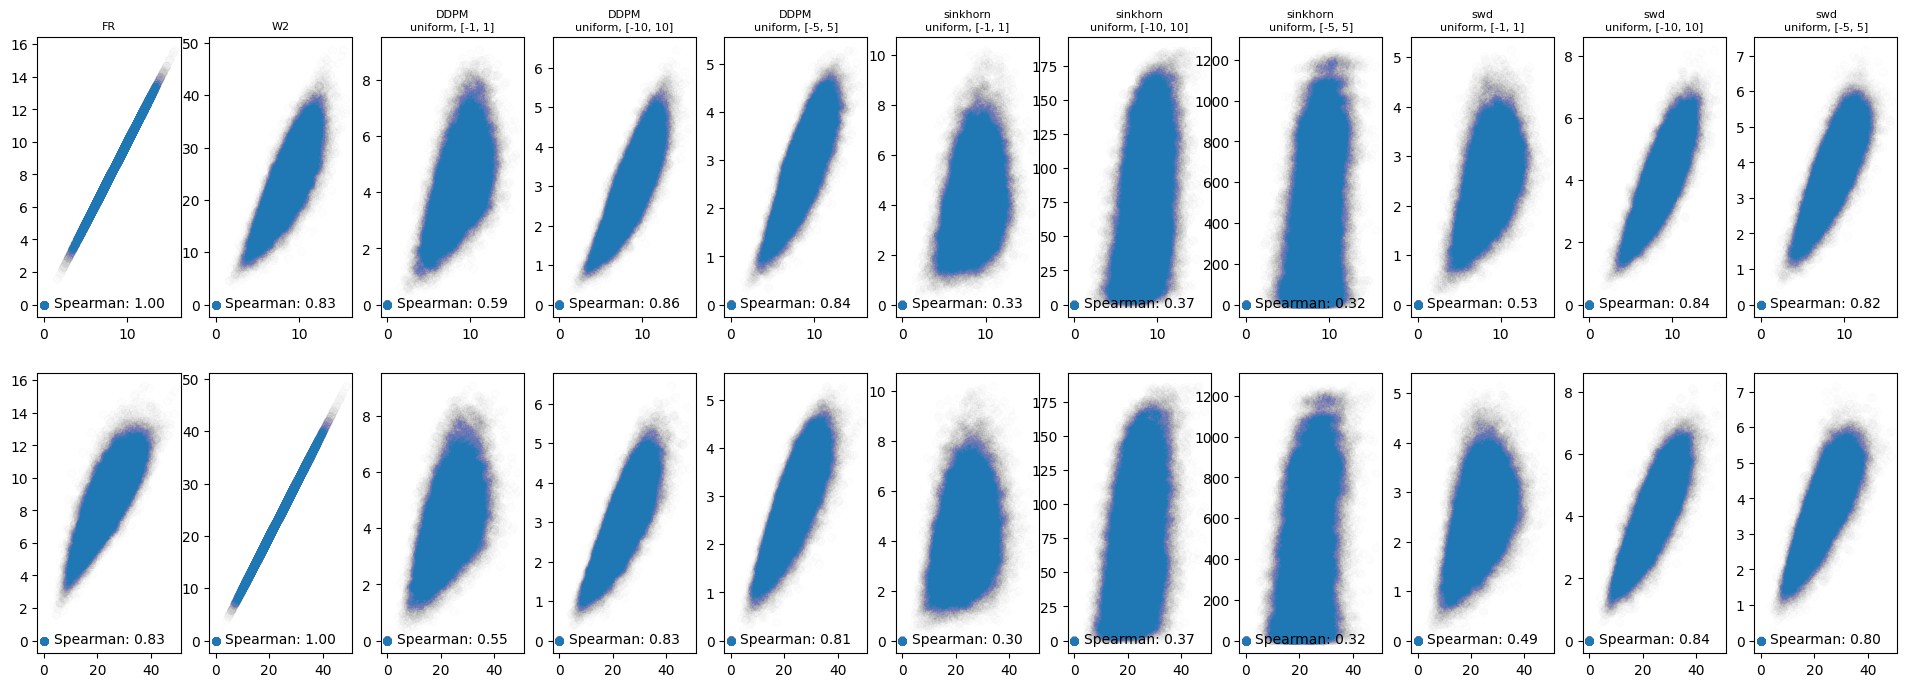

In [10]:
from matplotlib import pyplot as plt
import numpy as np
# plot each element of d against FR and W2
fr_dists = d['FR']
w2_dists = d['W2']
fig, axs = plt.subplots(2, len(d), figsize=(24, 8))
sorted_keys = sorted(d.keys(), key=lambda x: x[0] + str(x[1]) + str(x[2]) if isinstance(x, tuple) else x)
for i, key in enumerate(sorted_keys):
    value = d[key]
    print(key)
    # print(fr_dists.flatten().shape, value.flatten().shape)
    axs[0, i].scatter(fr_dists.flatten(), value.flatten(), alpha=0.005)
    axs[1, i].scatter(w2_dists.flatten(), value.flatten(), alpha=0.005)
    # add the spearman correlation coefficient to the plot
    # move the text to the bottom of the plot
    axs[0, i].text(0.5, 0.05, f'Spearman: {np.corrcoef(fr_dists.flatten(), value.flatten())[0, 1]:.2f}', ha='center', va='center', transform=axs[0, i].transAxes)
    axs[1, i].text(0.5, 0.05, f'Spearman: {np.corrcoef(w2_dists.flatten(), value.flatten())[0, 1]:.2f}', ha='center', va='center', transform=axs[1, i].transAxes)
    # add subplot titles based on the key
    axs[0, i].set_title(f'{key[0].split(".")[-1]}\n{key[1]}, {key[2]}' if isinstance(key, tuple) else key, fontsize=8)
    # axs[1, i].set_title(f'{key[0].split(".")[-1]}, {key[1]}, {key[2]}' if isinstance(key, tuple) else key)
    i += 1
plt.show()


In [32]:
from encoder.encoders import DistributionEncoderResNet

In [37]:
renc = DistributionEncoderResNet(5, 10, 10, 10)

In [38]:
renc.forward(torch.randn(10, 10, 5))

tensor([[ 0.1692, -0.3372,  0.3619, -0.5865, -0.3405,  0.6103,  0.0666,  0.6136,
          0.5065,  0.5123],
        [ 0.4089, -0.5223,  0.3903, -0.7310, -0.4552,  0.4754,  0.1526,  0.5220,
          0.5526,  0.6064],
        [ 0.1374, -0.3577,  0.4944, -0.9060, -0.1842,  0.9299,  0.6144,  1.0869,
          0.4897,  0.3440],
        [ 0.4158, -0.5095,  0.4765, -0.4912, -0.2026,  0.5542, -0.1349,  0.4707,
          0.5567,  0.7303],
        [ 0.2337, -0.3412,  0.3625, -0.9600, -0.2629,  0.7400,  0.5855,  0.9689,
          0.4404,  0.3948],
        [ 0.6177, -0.7400,  0.5123, -0.4744,  0.0763,  0.4984, -0.1904,  0.5318,
          0.5599,  0.7834],
        [ 0.7182, -0.7952,  0.6304, -0.5538,  0.1025,  0.5765,  0.1123,  0.5332,
          0.4655,  0.8444],
        [ 0.0623, -0.3046,  0.4744, -0.8561, -0.3703,  0.8403,  0.3755,  0.9988,
          0.5850,  0.3878],
        [ 0.9393, -0.9232,  0.5280, -0.2599,  0.0601,  0.1583, -0.6251,  0.1997,
          0.5263,  1.1027],
        [ 0.2072, -